In [1]:
# import standard packages

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as opt
import time
from datetime import datetime
from threading import Timer
import scipy.signal as sig
from scipy.interpolate import UnivariateSpline
from qkit.analysis.circle_fit.circle_fit_2019 import circuit

QKIT configuration initialized -> available as qkit.cfg[...]


# Qubit Characterization in Frequency Domain Notebook
This notebook exists to help you characterize your qubits in frequency domain! It covers measurements of the readout resonator up till sweeps in bias currents and drive tones.

Cells requiring your input a preceded by **bold text indicating user information.**

First, Qkit is initialized. **Input a unique run_id and your name below.**

In [2]:
# import and start qkit

import qkit
qkit.cfg['load_visa']=True
qkit.cfg['run_id']='EDEL_18'
qkit.cfg['user']=r'Alex'
qkit.start()

from qkit.storage.store import Data
import qkit.analysis.qfit as qfit
import qkit.measure.samples_class as sc

Starting QKIT framework ... -> qkit.core.startup
Loading module ... S10_logging.py
Loading module ... S14_setup_directories.py
Loading module ... S16_available_modules.py
Loading module ... S20_check_for_updates.py
Loading module ... S25_info_service.py
Loading module ... S30_qkit_start.py
Loading module ... S65_load_RI_service.py
Loading module ... S70_load_visa.py
Loading module ... S80_load_file_service.py
Loading module ... S85_init_measurement.py


Loading module ... S98_started.py
Loading module ... S99_init_user.py


# Import Instruments
The following instruments are required for operation and loaded:
- The microwave switch in the fridge to switch between samples
- A mircowave source for two-tone scans
- A current source to provide a magnetic field bias for field scans
- A VNA to perform the scan itself

## Microwave Switch
The Microwave Switch is loaded from configuration information, as this device is setup specific.
Here, the sample can be connected to the measurement devices.

**Make sure you are using the correct switch and pulse length!**

In [3]:
# create switch
switch = qkit.instruments.create_from_config("switch-edel") # Or "switch-perl"
switch.set_pulse_length(0.08) # Short pulse length to prevent excessive heating

Connecting to switch server...


In [ ]:
# switch.reset(2) # Uncomment and run if the switch is in an invalid state

In [ ]:
switch.ensure_switch_at(2, 3)

## Microwave Source
Again, a Microwave Source is loaded from the configuration file.
**Make sure you are using the correct device!**

In [10]:
mw_src = qkit.instruments.create_from_config("mw-134")

In [11]:
# turn on/off mw source
mw_src.set_status(False)
mw_src.get_status()

False

## Current Source (field bias)
**Ensure you are using the correct device!**

In [12]:
IVD = qkit.instruments.create_from_config("cs-129")

In [13]:
# settings

IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)
#IVD.set_bias_range(2e-1)
#IVD.set_sense_mode(1)
#IVD.set_sense_limit(0.5)
#IVD.get_all()

IVD.set_current(0)
IVD.set_status(0)
IVD.get_status()

False

## VNA
**Ensure you are using the correct device**

In [14]:
# create VNA
vna = qkit.instruments.create_from_config("vna-136")

## TIP Client (thermometer)
We can access the temperature readings in our cryostat automatically for documentation and logging purposes, as well as a 'safety' measure.

In case our current scan sends 'too much' current through the sample, it may become normal conducting and heat up. This is unwanted, and must be stopped as soon as possible, ideally without human intervention.

In [15]:
qkit.instruments.remove("tip")

# create thermometer
tip = qkit.instruments.create_from_config('tip-edel')

tip.define_default_thermometer('mxc')

def get_T():
    try:
        return tip.get_T() # Calls do_get_T and uses default thermometer to get attribute 'temperature'
    except:
        return np.nan # Why??????
get_T()

Connecting to TIP server...


0.008518933139047686

# Functions

In [16]:
# function estimates the duration of a measurement

def estimate_measurement_time(dim=2):
    if dim==1:
        t_meas = vna.get_sweeptime_averages()
    elif dim==2:
        t_meas = vna.get_sweeptime_averages()*s.x_vec.size
    elif dim==3:
        t_meas = vna.get_sweeptime_averages()*s.x_vec.size*s.y_vec.size
    timestamp = time.time()+t_meas
    
    if t_meas/60 < 180:
        print('Masurement duration: ' + str(round(t_meas/60,1)) + ' min, ends at ', datetime.fromtimestamp(timestamp))
    elif t_meas/60 >= 180:
        print('Masurement duration: ' + str(round(t_meas/3600,2)) + ' h, ends at ', datetime.fromtimestamp(timestamp))

    return 

In [17]:
# function returnes the wiki entry

def get_wiki_entry():
    print('| ', sep='', end='')
    print(s._data_file._uuid, sep='', end='')
    print(' |  | ', sep='', end='')
    if s._scan_dim > 1:
        print('{:f}{:s} to {:f}{:s} in {:f}{:s}'.format(s.x_vec[0],
                                                        s.x_unit,
                                                        s.x_vec[-1],
                                                        s.x_unit,
                                                        (s.x_vec[-1]-s.x_vec[0])/(s.x_vec.size-1),
                                                        s.x_unit),
              sep='', end='')
    else:
        print('---', sep='', end='')
    print(' | ', sep='', end='')
    if s._scan_dim > 2:
        print('{:f}{:s} to {:f}{:s} in {:f}{:s}'.format(s.y_vec[0],
                                                        s.y_unit,
                                                        s.y_vec[-1],
                                                        s.y_unit,
                                                        (s.y_vec[-1]-s.y_vec[0])/(s.y_vec.size-1),
                                                        s.y_unit),
              sep='', end='')
    else:
        print('---', sep='', end='')
    print(' | ', sep='', end='')
    print(vna.get_bandwidth(), ' | ', vna.get_averages(), ' | ', vna.get_power(), ' | ', vna.get_span()/1e6, ' | ', vna.get_nop(), ' | ', sep='', end='')
    print(IVD.get_current(), ' | ', mw_src.get_power(), ' | ', mw_src.get_frequency()/1e9, sep='', end='')
    print(' |  |', sep='', end='')

In [18]:
# functions used to implement a killswitch of the DC-current source depending on a cryo temperature threshold

temp_threshold = 15e-3 # mK

# Trigger function: True if the measured temperature exceeds the trigger temperature, False otherwise
def temperature_killswitch(trigger = temp_threshold):
    temp = get_T()
    if temp > trigger:
        return True
    else:
        return False
    
# Stop the DC current source
def stop_current():
    stop_point = IVD.get_current() # beware! get_current turns on current again
    IVD.set_current(0)
    IVD.set_status(False)
    sys.exit("Heat Stop at "+ str(stop_point/1e-3) + " mA; Current status: " +str(IVD.get_status()))

In [19]:
# Function to calculate measurement points, good eg. for ramping the current up and down
# INPUT: array with checkpoints that need to be reached in the measurement (eg. [start_value, stop_value]); step size
# OUTPUT: array with all corresponding measurement points
# WARNING: If used for sweeping a parameter up and back down and the step size does not correspond in the interval (eg. INPUT ([1, 8], 3)),
# the points on ramp up and ramp down will not correspond
def measurement_points(checkpoints, step):
    points = np.array([])
    step = abs(step)
    for i in range(1, len(checkpoints)):
        if checkpoints[i] > checkpoints[i-1]:
            points = np.append(points, np.arange(checkpoints[i-1], checkpoints[i], step))
        else:
            points = np.append(points, np.arange(checkpoints[i-1], checkpoints[i], -step))
    points = np.append(points, checkpoints[-1])
    return points

In [20]:
# Resonator calibration:

def resonator_calibration(f_r, mode):
    
    # Initialization
    mw_src.set_status(False) # turn off mw source during search
    vna.set_nop(401)
    vna.set_centerfreq(f_r)
    vna.set_span(20e6) # search the span aroud the resonator position
    vna.set_bandwidth(1000) # large IF bandwith, many averages
    vna.set_averages(30)
    vna.set_Average(True)
    
    # Resonator measurement with MW source OFF
    vna.pre_measurement() # Trigger count is set to number of averages
    vna.start_measurement() # Averages are reset; set_sweep_mode("group")
    while not vna.ready(): # wait till end of measurement
        if temperature_killswitch():
            stop_current()
            return 
        else:
            time.sleep(1e-1)
    
    # Find reesonance frequency in smoothened phase data, set this to be the center frequency
    s.freq = vna.get_freqpoints()
    s.amp, s.pha = vna.get_tracedata() # dataset with the amp and phase data to find the resonator
    try:
        if mode == 'phase':
            # Savitzky-Golay-Filter:
            # digital smoothing filter, increases the precision without distorting the signal tendency
            # Convolution of low-degree polynomial over the data and fit
            pha_savgol = - sig.savgol_filter(s.pha, window_length=9, polyorder=3, deriv=1)
            peaks = sig.find_peaks(pha_savgol, prominence=4e-2)
            peak = sig.find_peaks(pha_savgol, prominence=np.max(peaks[1]['prominences']))
        elif mode == 'amplitude'
        return s.freq[peak[0][0]]
    except:
        return 0

SyntaxError: invalid syntax (2213856114.py, line 35)

In [21]:
# Set bias flux/current

def set_dc_bias(dc_bias, mode = "set", dc_time = 0.1):
    max_current = 8.0e-3 # max. dc current allowed
    dc_step = 10e-6
    
    # if None then turn off source
    if dc_bias == None:
        IVD.set_status(False)
        return "DC source turned off."
    
    # check, if current value does not exceed maximum value
    if abs(dc_bias) > max_current:
        return "Please select a DC current bias value lower than " + str(max_current) + " A!"
        
    # set current source to zero and turn on source
    IVD.set_current(0)
    IVD.set_measurement_mode(0)
    IVD.set_bias_mode(0)
    IVD.set_status(True)
    
    # set or ramp current
    if mode == "set":
        IVD.set_current(dc_bias)
    elif mode == "ramp":
        IVD.ramp_current(dc_bias, dc_step, dc_time)
    
    return "DC source set to " + str(round(IVD.get_current()*1e3,3)) + " mA"

# Measurements
## Sample Information
Each Notebook should contain a single sample. In this case, each Notebook handles a single Qubit. This way variables are isolated within a python kernel and from each other.

**Please define your sample below**

In [ ]:
sample = sc.Sample()
sample.name = 'GeQCoS-4Q-v4-3-C28-R2'
sample.temperature = '~10mK'
sample.setup = 'directional coupler: -20 dBm, damping at mw source -20 dBm'
print(sample.get_all())

exp_name = "GeQCoS4Qv4_3_C28_r2"

from qkit.measure.spectroscopy.spectroscopy import spectrum
s = spectrum(vna, exp_name=exp_name, sample=sample)
s.exp_name=exp_name

dir_sample = fr"{qkit.cfg['user']}\\{exp_name}"
qkit.cfg['user'] = dir_sample

**Configure your sample parameters in the following cell:**

In [ ]:
res_freq = 7.748e9

def initial_calibration(delay = 58.039e-9):
    vna.set_measurement_parameter('S21')
    vna.set_power(-35)
    vna.set_bandwidth(100)
    vna.set_span(20e6)
    vna.set_nop(101)
    vna.set_centerfreq(res_freq)
    vna.do_set_edel_status(True) # port extension
    vna.do_set_edel(delay, 1)
    return

initial_calibration()

In [26]:
vna.set_centerfreq(res_freq)

True

## Resonator Measurement

### 1D Trace

In [179]:
# set the flux bias
set_dc_bias(0)

'DC source set to -0.0 mA'

In [180]:
IVD.get_status()

True

In [135]:
# Measurement parameters

# VNA 
vna_power = -35 # dBm
vna_nop  = 201 
vna_span = 10e6 # Hz
vna_avg = 3
vna_bw = 50 # Hz

In [136]:
vna.set_power(vna_power)

True

In [137]:
vna.set_nop(vna_nop)
vna.set_span(vna_span)

True

In [58]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [138]:
vna.set_bandwidth(vna_bw)

True

In [63]:
s.set_resonator_fit(fit_resonator=True, fit_function='circle_fit_reflection')

In [163]:
qkit.cfg['user']= dir_sample + r'\\Resonator_Trace'
s.dirname = exp_name + "_1D_scan"

In [164]:
s.measure_1D()

HTML(value="<table style='width:100%'><tr><td> (0/1) </td><td>&#9992; 2023-04-18 (Tue) 13:09:01    </td><td>&#…

IntProgress(value=0, description='GeQCoS4Qv4_3_C28_r3_1D_scan', layout=Layout(width='95%'), max=1)

C:\data\EDEL_18\Alex\\sample_C28\\Resonator_Trace\RTB5MZ_GeQCoS4Qv4_3_C28_r3_1D_scan\RTB5MZ_GeQCoS4Qv4_3_C28_r3_1D_scan.h5


### 2D Power scan

In [85]:
# set the flux bias
dc_bias = 1200e-6
set_dc_bias(dc_bias)

'DC source set to 1.2 mA'

In [121]:
IVD.get_status()

True

In [122]:
# Measurement parameters

# Power sweep
power_start = -80 # dBm
power_stop = 10 # dBm
power_step = 2 # dBm

power_points = measurement_points([power_start, power_stop], power_step)

# VNA 
vna_nop  = 401 
vna_span = 20e6 # Hz
vna_avg = 10
vna_bw = 50 # Hz

In [124]:
vna.set_span(vna_span)
vna.set_nop(vna_nop)

True

In [125]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [126]:
vna.set_bandwidth(vna_bw)

True

In [127]:
s.set_resonator_fit(fit_resonator=False, fit_function='circle_fit_reflection')

In [128]:
s.set_x_parameters(x_vec=power_points,
                   x_coordname='VNA_power', 
                   x_set_obj=vna.set_power, 
                   x_unit='dBm')

estimate_measurement_time(2)

Masurement duration: 59.0 min, ends at  2023-04-16 17:43:27.551669


In [129]:
vna.set_power(power_start)

True

In [131]:
s.comment = """Directional coupler : -20dBm VNA, MW source: - 20 dBm external"""
#s.comment = """no directional coupler"""

In [ ]:
name_extension = "_at_" + str(round(dc_bias*1e6,0)) +"µA_bias_" + "(full_Phi0)"
qkit.cfg['user']= dir_sample + r'\\Resonator_Power'
s.dirname = exp_name + "_powerscan_" + str(int(power_start)) + "_to_" + str(int(power_stop)) + "_dBm" + name_extension

In [132]:
s.measure_2D()
vna.set_power(power_start)

HTML(value="<table style='width:100%'><tr><td> (0/46) </td><td>&#9992; 2023-04-16 (Sun) 17:44:17    </td><td>&…

IntProgress(value=0, description='2D VNA sweep GeQCoS4Qv4_3_C28_r3_powerscan_-80_to_10_dBm_at_1200µA_bias_(ful…

C:\data\EDEL_18\Alex\RT7QBF_2D_GeQCoS4Qv4_3_C28_r3_powerscan_-80_to_10_dBm_at_1200µA_bias_(full_Phi0)\RT7QBF_2D_GeQCoS4Qv4_3_C28_r3_powerscan_-80_to_10_dBm_at_1200µA_bias_(full_Phi0).h5


True

### 2D Current scan

In [30]:
# set the flux bias
set_dc_bias(400e-6)

'DC source set to 0.4 mA'

In [28]:
IVD.get_status()

True

In [48]:
dc_start = -5e-3 # A
dc_stop = 5e-3 # A
dc_step = 0.005e-3 # A

current_points = measurement_points([dc_start, dc_stop], dc_step)

dc_time = 0.25

# VNA 
vna_nop  = 401 
vna_span = 80e6 # Hz
vna_avg = 1
vna_bw = 80 # Hz
vna_power = -35 # dB

In [49]:
vna.set_power(vna_power)

True

In [50]:
vna.set_span(vna_span)
vna.set_nop(vna_nop)

True

In [51]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [52]:
vna.set_bandwidth(vna_bw)

True

In [53]:
def x_function(i):
    #IVD.set_current(i)
    """
    set_current(self, val, channel=1):
    
    Sets current value of channel <channel> to <val>.

    Parameters
    ----------
    val: float
        Bias current value.
    channel: int
        Number of channel of interest. Must be 1 for SMUs with only one channel and 1 or 2 for SMUs with two channels. Default is 1.
    """
    
    IVD.ramp_current(i, dc_step, dc_time)
    """
    ramp_current(self, stop, step, step_time=0.1, channel=1):
    
    Ramps current of channel <channel> from recent value to stop value <stop> with step size <step> and step time <step_time> according to bias_mode.

    Parameters
    ----------
    stop: float
        Stop current value
    step: float
        Step current size.
    step_time: float
        Sleep time between current staircase ramp.
    channel: int
        Number of channel of interest. Must be 1 for SMUs with only one channel and 1 or 2 for SMUs with two channels. Default is 1. (default)
    """
    
s.set_x_parameters(x_vec=current_points,
                   x_coordname='current_bias', 
                   x_set_obj=x_function, 
                   x_unit='Amp')

estimate_measurement_time(2)

Masurement duration: 3.06 h, ends at  2023-04-19 13:04:37.038661


In [54]:
s.comment = """Directional coupler : -20dBm VNA, MW source: - 20 dBm external"""
#s.comment = """no directional coupler"""

In [55]:
qkit.cfg['user']= dir_sample + r'\\Resonator_Current'
s.dirname = exp_name + "_current_sweep_" + str(round(dc_start/1e-3,1)) + "_to_" + str(round(dc_stop/1e-3,1)) + "_mA"

In [56]:
IVD.set_current(0)
IVD.set_status(True)
IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)

In [57]:
#IVD.ramp_current(dc_start, dc_step, dc_time)
IVD.set_current(dc_start)

In [ ]:
s.measure_2D()

IVD.set_current(0)
IVD.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/2001) </td><td>&#9992; 2023-04-19 (Wed) 13:05:17    </td><td…

IntProgress(value=0, description='2D VNA sweep GeQCoS4Qv4_3_C28_r4_current_sweep_-5.0_to_5.0_mA', layout=Layou…

## Two Tone Measurements

### 2D 2-tone

In [59]:
# set the flux bias
dc_bias = 600e-6
set_dc_bias(dc_bias)

'DC source set to 0.6 mA'

In [58]:
IVD.get_status()

True

In [60]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

7837600472.63

In [68]:
# Measurement parameter

# mw drive
mw_start = 7.9e9 # Hz
mw_stop = 12.0e9 # Hz
mw_step = 5e6 # Hz
mw_power = 5 # -20 dBm is max without eternal damping

mw_points = measurement_points([mw_start, mw_stop], mw_step)

# VNA
vna_nop  = 401 
vna_span = 20e6 # Hz
vna_avg = 10
vna_bw = 50 # Hz
vna_power = -40 # dB

In [123]:
vna.set_power(vna_power)

True

In [124]:
vna.set_span(vna_span)
vna.set_nop(vna_nop)

True

In [69]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [70]:
vna.set_bandwidth(vna_bw)

True

In [ ]:
# Measurement with one point: One point (centerfreq) in amp. dip or phase edge

"""
res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(1)
"""

In [ ]:
# Measurement with two points: One point (centerfreq) in amp. dip or phase edge and second point about 500 KHz left or right 

"""
vna.set_startfreq(res_freq)
vna.set_stopfreq(res_freq+300e3)
vna.set_nop(2)
"""

True

In [66]:
# Measurement with three points: One point (centerfreq) in amp. dip or phase edge and one point left and right each (baseline)

res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(3)

True

In [71]:
s.set_x_parameters(x_vec=mw_points,
                   x_coordname='mw_frequency', 
                   x_set_obj=mw_src.set_frequency, 
                   x_unit='Hz')

estimate_measurement_time(2)

Masurement duration: 7.9 min, ends at  2023-04-18 22:20:52.078545


In [72]:
s.comment = """Directional coupler : -20dBm VNA, MW source: - 20 dBm external"""
#s.comment = """no directional coupler"""

In [73]:
name_extension = "_at_" + str(round(dc_bias*1e6,0)) +"µA_bias_" + "(full_Phi0)"
qkit.cfg['user']= dir_sample + r'\\TwoTone_Trace'
s.dirname = exp_name + "_2tone_at_" +  str(round(mw_power,1)) + "_dBm_" + str(round(mw_start/1e9,1)) + "_to_" + str(round(mw_stop/1e9,1)) + "_GHz" + str(round(mw_step/1e6,1)) + "_MHz_step" + name_extension

In [74]:
mw_src.set_power(mw_power)
mw_src.set_status(True)

s.measure_2D()

mw_src.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/821) </td><td>&#9992; 2023-04-18 (Tue) 22:21:08    </td><td>…

IntProgress(value=0, description='2D VNA sweep GeQCoS4Qv4_3_C28_r1_2tone_at_5_dBm_7.9_to_12.0_GHz5.0_MHz_step_…

C:\data\EDEL_18\Alex\\sample_C28\\TwoTone_Trace\RTBUU3_2D_GeQCoS4Qv4_3_C28_r1_2tone_at_5_dBm_7.9_to_12.0_GHz5.0_MHz_step_at_600µA_bias_(full_Phi0)\RTBUU3_2D_GeQCoS4Qv4_3_C28_r1_2tone_at_5_dBm_7.9_to_12.0_GHz5.0_MHz_step_at_600µA_bias_(full_Phi0).h5


True

In [53]:
dc_start = -5e-3#e-3#-1e-3 # A
dc_stop = 5e-3 # A
dc_step = 0.01e-3 # A
dc_time = 0.1

def x_function(i):
    #IVD.set_current(i)
    """
    set_current(self, val, channel=1):
    
    Sets current value of channel <channel> to <val>.

    Parameters
    ----------
    val: float
        Bias current value.
    channel: int
        Number of channel of interest. Must be 1 for SMUs with only one channel and 1 or 2 for SMUs with two channels. Default is 1.
    """
    
    IVD.ramp_current(i, dc_step, dc_time)
    """
    ramp_current(self, stop, step, step_time=0.1, channel=1):
    
    Ramps current of channel <channel> from recent value to stop value <stop> with step size <step> and step time <step_time> according to bias_mode.

    Parameters
    ----------
    stop: float
        Stop current value
    step: float
        Step current size.
    step_time: float
        Sleep time between current staircase ramp.
    channel: int
        Number of channel of interest. Must be 1 for SMUs with only one channel and 1 or 2 for SMUs with two channels. Default is 1. (default)
    """
    
s.set_x_parameters(x_vec=np.arange(dc_start, dc_stop, dc_step),
                   x_coordname='current_bias', 
                   x_set_obj=x_function, 
                   x_unit='Amp')
vna.get_sweeptime_averages()*len(s.x_vec)

1929.94552003

In [54]:
vna.set_averages(5)

True

In [55]:
#IVD.ramp_current(1e-3, dc_step, dc_time)
IVD.set_current(0)

In [60]:
IVD.get_status()

False

In [57]:
IVD.set_status(True)
IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)

In [58]:
IVD.ramp_current(dc_start, dc_step, dc_time)

In [59]:
s.dirname=exp_name + "_current_sweep_" + str(round(dc_start/1e-3,1)) + "_to_" + str(round(dc_stop/1e-3,1)) + "_mA"
s.measure_2D()

IVD.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; 2023-04-12 (Wed) 17:15:23    </td><td…

IntProgress(value=0, description='2D VNA sweep GeQCoS4Qv4_3_C28_r3_current_sweep_-5.0_to_5.0_mA', layout=Layou…

C:\data\EDEL_18\Alex\RT0BK2_2D_GeQCoS4Qv4_3_C28_r3_current_sweep_-5.0_to_5.0_mA_GeQCoS4Qv4_3_C28_r3\RT0BK2_2D_GeQCoS4Qv4_3_C28_r3_current_sweep_-5.0_to_5.0_mA_GeQCoS4Qv4_3_C28_r3.h5


### 3D 2-tone power sweep

In [85]:
# set the flux bias
dc_bias = -55e-6
set_dc_bias(dc_bias)

'DC source set to -0.055 mA'

In [39]:
IVD.get_status()

True

In [29]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

7831491414.64

In [52]:
# Measurement parameter

# mw drive
mw_start = 0.5e9 # Hz
mw_stop = 8.0e9 # Hz
mw_step = 5e6 # Hz

mw_points = measurement_points([mw_stop, mw_start], mw_step)
    
power_start = -20 # dBm
power_stop = 0 # dBm
power_step = 5 # dBm

mw_power_points = measurement_points([power_start, power_stop], power_step)

# VNA
vna_nop  = 401 
vna_span = 15e6 # Hz
vna_avg = 5
vna_bw = 50 # Hz
vna_power = -40 # dB

In [53]:
mw_src.set_status(False)

True

In [54]:
vna.set_power(vna_power)

True

In [55]:
vna.set_span(vna_span)
vna.set_nop(vna_nop)

True

In [56]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [57]:
vna.set_bandwidth(vna_bw)

True

In [58]:
# Measurement with one point: One point (centerfreq) in amp. dip or phase edge

"""
res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(1)
"""

'\nres_freq = vna.get_centerfreq()\nvna.get_centerfreq()\nvna.set_nop(1)\n'

In [ ]:
# Measurement with two points: One point (centerfreq) in amp. dip or phase edge and second point about 500 KHz left or right 

"""
vna.set_startfreq(res_freq)
vna.set_stopfreq(res_freq+300e3)
vna.set_nop(2)
"""

True

In [59]:
# Measurement with three points: One point (centerfreq) in amp. dip or phase edge and one point left and right each (baseline)

res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(3)

True

In [60]:
s.set_x_parameters(x_vec=mw_power_points,
                   x_coordname='mw_power', 
                   x_set_obj=mw_src.set_power, 
                   x_unit='dBm')

s.set_y_parameters(y_vec=mw_points,
                   y_coordname='mw_frequency', 
                   y_set_obj=mw_src.set_frequency, 
                   y_unit='Hz')

estimate_measurement_time(3)

Masurement duration: 36.0 min, ends at  2023-04-19 00:35:19.402363


In [61]:
s.comment = """Directional coupler : -20dBm VNA, MW source: - 20 dBm external"""
#s.comment = """no directional coupler"""

In [62]:
name_extension = "_at_" + str(round(dc_bias*1e6,0)) +"µA_bias_" + "(full_Phi0)"
qkit.cfg['user']= dir_sample + r'\\TwoTone_Power'
s.dirname = exp_name + "_2tone_" + str(round(mw_start/1e9,1)) + "_to_" + str(round(mw_stop/1e9,1)) + "_GHz_power_" + str(power_start) + "_to_" + str(power_stop) + "_dBm" + name_extension

In [63]:
mw_src.set_power(power_start)
mw_src.set_status(True)

s.measure_3D()

mw_src.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/7505) </td><td>&#9992; 2023-04-19 (Wed) 00:35:33    </td><td…

IntProgress(value=0, description='3D VNA sweep GeQCoS4Qv4_3_C28_r1_2tone_0.5_to_8.0_GHz_power_-20_to_0_dBm_at_…

C:\data\EDEL_18\Alex\\sample_C28\\TwoTone_Power\RTBZR7_3D_GeQCoS4Qv4_3_C28_r1_2tone_0.5_to_8.0_GHz_power_-20_to_0_dBm_at_150µA_bias\RTBZR7_3D_GeQCoS4Qv4_3_C28_r1_2tone_0.5_to_8.0_GHz_power_-20_to_0_dBm_at_150µA_bias.h5


True

### 3D 2-tone Current sweep

In [1]:
# set the flux bias
dc_bias = 400e-6
set_dc_bias(dc_bias)

NameError: name 'set_dc_bias' is not defined

In [2]:
IVD.get_status()

NameError: name 'IVD' is not defined

In [52]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

In [64]:
# Measurement parameter

# field bias
dc_start = 400e-6 # A
dc_stop = 800e-6 # A
dc_step = 10e-6 # A

current_points = measurement_points([dc_start, dc_stop], dc_step)

dc_time = 0.25

# mw drive
mw_start = 6.5e9 # Hz
mw_stop = 8.0e9 # Hz
mw_step = 5e6 # Hz

mw_points = measurement_points([mw_start, mw_stop], mw_step)

mw_power = -20

# VNA
vna_nop  = 401 
vna_span = 20e6 # Hz
vna_avg = 10
vna_bw = 50 # Hz
vna_power = -35 # dB

In [65]:
mw_src.set_status(False)

True

In [123]:
vna.set_power(vna_power)

True

In [124]:
vna.set_span(vna_span)
vna.set_nop(vna_nop)

True

In [125]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [126]:
vna.set_bandwidth(vna_bw)

True

In [ ]:
# Measurement with one point: One point (centerfreq) in amp. dip or phase edge

"""
res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(1)
"""

In [ ]:
# Measurement with two points: One point (centerfreq) in amp. dip or phase edge and second point about 500 KHz left or right 

"""
vna.set_startfreq(res_freq)
vna.set_stopfreq(res_freq+300e3)
vna.set_nop(2)
"""

True

In [66]:
# Measurement with three points: One point (centerfreq) in amp. dip or phase edge and one point left and right each (baseline)

res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(3)

True

In [69]:
def x_function(i):
    #IVD.set_current(i) 
    IVD.ramp_current(i, dc_step, dc_time)

# x parameters for field sweep
s.set_x_parameters(x_vec=current_points,
                   x_coordname='current_bias', 
                   x_set_obj=x_function, 
                   x_unit='Amp')

# y parameters for mw source
s.set_y_parameters(y_vec=mw_points,
                   y_coordname='mw_frequency', 
                   y_set_obj=mw_src.set_frequency, 
                   y_unit='Hz')

estimate_measurement_time(3)

Masurement duration: 59.2 min, ends at  2023-04-19 09:27:53.634609


In [70]:
s.comment = """Directional coupler : -20dBm VNA, MW source: - 20 dBm external"""
#s.comment = """no directional coupler"""

In [71]:
qkit.cfg['user']= dir_sample + r'\\TwoTone_Current'
s.dirname = exp_name + "_2tone_" + str(round(mw_start/1e9,1)) + "_to_"  + str(round(mw_stop/1e9,1)) + "_GHz_current_" + str(round(dc_start/1e-3,1)) + "_to_"  + str(round(dc_stop/1e-3,1)) + "_mA"

In [73]:
IVD.set_current(dc_start)
IVD.set_status(True)
IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)

In [58]:
IVD.ramp_current(dc_start, dc_step, dc_time)

In [64]:
mw_src.set_power(power_start)
mw_src.set_status(True)

s.measure_3D()

mw_src.set_status(False)
IVD.set_current(0)
IVD.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/1040) </td><td>&#9992; 2023-04-12 (Wed) 13:42:59    </td><td…

IntProgress(value=0, description='3D VNA sweep GeQCoS4Qv4_3_C28_r3_2tone_6.2_to_7.0_GHz_power_-100_to_20_dBm',…

C:\data\EDEL_18\Alex\RT0323_3D_GeQCoS4Qv4_3_C28_r3_2tone_6.2_to_7.0_GHz_power_-100_to_20_dBm_GeQCoS4Qv4_3_C28_r3\RT0323_3D_GeQCoS4Qv4_3_C28_r3_2tone_6.2_to_7.0_GHz_power_-100_to_20_dBm_GeQCoS4Qv4_3_C28_r3.h5


True

### 3D 2-tone Current sweep + readout resonator calibration

In [ ]:
# initial_calibration_R1()
# initial_calibration_R2()
# initial_calibration_R3()
# initial_calibration_R4()

In [24]:
# set the flux bias
dc_bias = 400e-6
set_dc_bias(dc_bias)

In [ ]:
IVD.get_status()

In [25]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

7858121125.27

In [27]:
# Measurement parameter

# field bias
dc_start = -80e-6 # A
dc_stop = -30e-6 # A
dc_step = 2e-6 # A

current_points = measurement_points([dc_start, dc_stop], dc_step)

dc_time = 0.25

# mw drive
mw_start = 6.5e9 # Hz
mw_stop = 8.0e9 # Hz
mw_step = 5e6 # Hz

mw_points = measurement_points([mw_start, mw_stop], mw_step)

mw_power = -20

# VNA
vna_nop  = 1  # measurement with one point in dip
vna_span = 20e6 # Hz

vna_avg = 10
vna_bw = 50 # Hz
vna_power = -35 # dB

# resonator calibration
cal_nop = 801
cal_span = 40e6
cal_bw = 1000
cal_avg = 20

In [28]:
def x_function(i):   
    IVD.ramp_current(i, dc_step, dc_time)
    
    # search for optimal working point of resonator (VNA)
    mw_src.set_status(False) # turn off mw source during search
    vna.set_nop(cal_nop)
    vna.set_centerfreq(res_freq)
    vna.set_span(cal_span) # search the span aroud the resonator position
    vna.set_bandwidth(cal_bw) # large IF bandwith, many averages
    vna.set_averages(cal_avg)
    vna.set_Average(True)

    vna.pre_measurement()
    vna.start_measurement()
    while not vna.ready(): # wait till end of measurement
        time.sleep(1e-1)
    s.freq = vna.get_freqpoints()
    s.amp, s.pha = vna.get_tracedata() # dataset with the amp and phase data to tind the resonator
    try:
        # Savitzky-Golay-Filter
        #pha_savgol = -sig.savgol_filter(s.pha, window_length=9, polyorder=3, deriv=1)
        peaks = sig.find_peaks(-s.amp, prominence= 1e-3)
        peak = sig.find_peaks(-s.amp, prominence=np.max(peaks[1]['prominences']))
        s.centerfreq = s.freq[peak[0][0]]
    except:
        pass
    """ set VNA-frequency to resonant frequency """
    vna.set_nop(vna_nop)
    vna.set_span(vna_span)
    vna.set_centerfreq(s.centerfreq)
    vna.set_bandwidth(vna_bw)
    vna.set_Average(True)
    vna.set_averages(vna_avg)
    vna.pre_measurement()
    mw_src.set_status(True)

# x parameters for field sweep
s.set_x_parameters(x_vec=current_points,
                   x_coordname='current_bias', 
                   x_set_obj=x_function, 
                   x_unit='Amp')

# log entry for centerfrequency
s.set_log_function(func=(lambda: s.centerfreq, ),
                   name=('centerfreq', ),
                   unit=('Hz', ))

In [ ]:
vna.set_power(vna_power)

In [29]:
IVD.ramp_current(s.x_vec[0], dc_start)
x_function(s.x_vec[0])

In [30]:
# y parameters for mw source
s.set_y_parameters(y_vec=mw_points,
                   y_coordname='mw_frequency', 
                   y_set_obj=mw_src.set_frequency, 
                   y_unit='Hz')

In [31]:
mw_src.set_frequency(mw_start)
mw_src.set_power(mw_power)
mw_src.set_status(True)

True

In [32]:
s.comment = """Directional coupler : -20dBm VNA, MW source: - 20 dBm external"""
#s.comment = """no directional coupler"""

In [33]:
name_extension = ""
qkit.cfg['user']= dir_sample + r'\\TwoTone_Power'
s.dirname = exp_name + "_2tone_" + str(round(mw_start/1e9,1)) + "_to_" + str(round(mw_stop/1e9,1)) + "_GHz_power_" + str(power_start) + "_to_" + str(power_stop) + "_dBm" + name_extension

NameError: name 'power_start' is not defined

In [ ]:
mw_src.set_frequency(mw_start)
mw_src.set_power(mw_power)
mw_src.set_status(True)

s.measure_3D()

mw_src.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/5400) </td><td>&#9992; 2023-04-19 (Wed) 09:56:58    </td><td…

IntProgress(value=0, description='3D VNA sweep current_bias, mw_frequency', layout=Layout(width='95%'), max=54…

In [ ]:
s.comment = """Directional coupler : -20dBm VNA, MW @ Input, -10dBm @ MW source"""

In [ ]:
IVD.ramp_current(dc_start, dc_step, dc_time)
IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)

In [ ]:
s.dirname = exp_name + "_2tone_" + str(round(mw_start/1e9,1)) + "_to_"  + str(round(mw_stop/1e9,1)) + "_GHz_current_" + str(round(dc_start/1e-3,1)) + "_to_"  + str(round(dc_stop/1e-3,1)) + "_mA"
IVD.set_status(True)
mw_src.set_status(True)
s.measure_3D()
mw_src.set_status(False)
IVD.set_status(False)

In [ ]:
IVD.set_status(False)
IVD.get_status()

## 3D 2-tone B-field (current) sweep (readout resonator calibration + landscape)

### readout resonator calibration test

In [37]:
res_freq = vna.get_centerfreq()

In [35]:
# search for optimal working point of resonator (VNA)
mw_src.set_status(False) # turn off mw source during search
vna.set_nop(801)
vna.set_centerfreq(res_freq)
vna.set_span(40e6) # search the span aroud the resonator position
vna.set_bandwidth(1000) # large IF bandwith, many averages
vna.set_averages(20)
vna.set_Average(True)


s.measure_1D()

HTML(value="<table style='width:100%'><tr><td> (0/20) </td><td>&#9992; 2023-04-13 (Thu) 14:22:51    </td><td>&…

IntProgress(value=0, description='VNA_tracedata', layout=Layout(width='95%'), max=20)

C:\data\EDEL_18\Alex\RT1ZPN_VNA_tracedata_GeQCoS4Qv4_3_C28_r3\RT1ZPN_VNA_tracedata_GeQCoS4Qv4_3_C28_r3.h5


In [16]:
s.freq = vna.get_freqpoints()
s.amp, s.pha = vna.get_tracedata() # dataset with the amp and phase data to tind the resonator

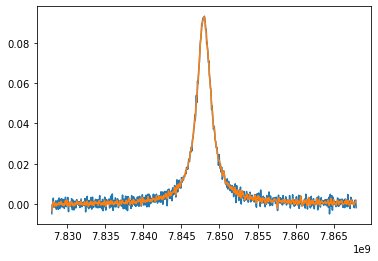

In [17]:
plt.plot(s.freq, -np.gradient(s.pha))
pha_savgol = -sig.savgol_filter(s.pha, window_length=9, polyorder=3, deriv=1)
plt.plot(s.freq, pha_savgol)

In [22]:
# Savitzky-Golay-Filter
pha_savgol = -sig.savgol_filter(s.pha, window_length=9, polyorder=3, deriv=1)
#print(pha_savgol)
peaks = sig.find_peaks(pha_savgol, prominence= 4e-2)
peak = sig.find_peaks(pha_savgol, prominence=np.max(peaks[1]['prominences']))
s.centerfreq = s.freq[peak[0][0]]
print(str(round(s.centerfreq/1e9, 3)) + " GHz")

7.848 GHz


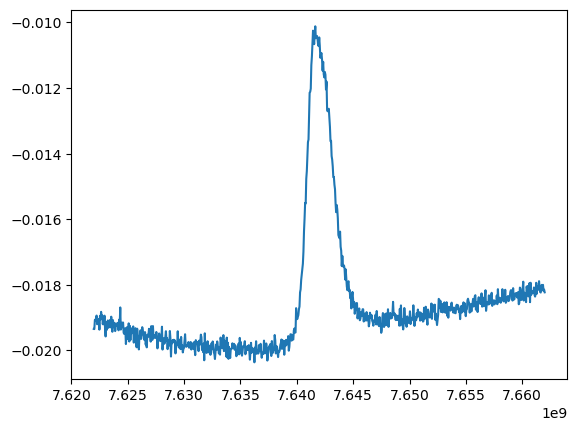

In [42]:
plt.plot(s.freq, -s.amp)

In [70]:
peaks = sig.find_peaks(-s.amp, prominence= 1e-3)
peak = sig.find_peaks(-s.amp, prominence=np.max(peaks[1]['prominences']))
s.centerfreq = s.freq[peak[0][0]]
print(str(round(s.centerfreq/1e9, 3)) + " GHz")
#print(peaks)

7.642 GHz


### Measurement setup

In [37]:
qkit.instruments.remove("vna")

In [38]:
vna = qkit.instruments.create("VNA", "Keysight_VNA_E5080B", address="TCPIP0::10.22.197.136::INSTR")
from qkit.measure.spectroscopy.spectroscopy import spectrum
s = spectrum(vna)

2022-12-22 16:25:21 [WARNING ]: Instrument "VNA" already exists, removing (instrument_tools.py:222)


In [28]:
vna.set_measurement_parameter('S21')
vna.set_power(-30)
vna.set_bandwidth(500)
vna.set_span(40e6)

True

In [29]:
# Measurement parameter

# field bias
dc_start = -8.0e-3 # A
dc_stop = 15.0e-3 # A
dc_step = 0.25e-3 # A
dc_time = 0.1

# mw drive
mw_start = 8.7e9 # Hz
mw_stop = 9.65e9 # Hz
mw_step = 5e6 # Hz
mw_power = -10

# VNA
vna_avg = 10
vna_bandwith = 50
vna_span = 5e6
vna_power = -30

vna.set_power(vna_power)
res_freq = vna.get_centerfreq()

In [30]:
def x_function(i):
    # set current source
    #IVD.set_current(i)
    
    IVD.ramp_current(i, dc_step, dc_time)
    
    # search for optimal working point of resonator (VNA)
    mw_src.set_status(False) # turn off mw source during search
    vna.set_nop(801)
    vna.set_centerfreq(res_freq)
    vna.set_span(40e6) # search the span aroud the resonator position
    vna.set_bandwidth(1000) # large IF bandwith, many averages
    vna.set_averages(20)
    vna.set_Average(True)

    vna.pre_measurement()
    vna.start_measurement()
    while not vna.ready(): # wait till end of measurement
        time.sleep(1e-1)
    s.freq = vna.get_freqpoints()
    s.amp, s.pha = vna.get_tracedata() # dataset with the amp and phase data to tind the resonator
    try:
        # Savitzky-Golay-Filter
        pha_savgol = -sig.savgol_filter(s.pha, window_length=9, polyorder=3, deriv=1)
        peaks = sig.find_peaks(pha_savgol, prominence=4e-2)
        peak = sig.find_peaks(pha_savgol, prominence=np.max(peaks[1]['prominences']))
        s.centerfreq = s.freq[peak[0][0]]
    except:
        pass
    """ set VNA-frequency to resonant frequency """
    vna.set_nop(1)
    vna.set_span(vna_span)
    vna.set_centerfreq(s.centerfreq)
    vna.set_bandwidth(vna_bandwith)
    vna.set_Average(True)
    vna.set_averages(vna_avg)
    vna.pre_measurement()
    mw_src.set_status(True)

# x parameters for field sweep
s.set_x_parameters(x_vec=np.arange(dc_start, dc_stop+dc_step, dc_step),
                   x_coordname='current_bias', 
                   x_set_obj=x_function, 
                   x_unit='Amp')

# log entry for centerfrequency
s.set_log_function(func=(lambda: s.centerfreq, ),
                   name=('centerfreq', ),
                   unit=('Hz', ))

In [31]:
IVD.ramp_current(s.x_vec[0], 1e-3)
x_function(s.x_vec[0])

In [32]:
# y parameters for mw source
def y_function(i):
    if i == 0:
        mw_src.set_status(False)
    else:
        mw_src.set_frequency(i)
        mw_src.set_status(True)
        #mw_src.set_power(-27.5 + 2.5e-9 * i) # overcome frequency dependent cable attenuation

s.set_y_parameters(y_vec=np.arange(mw_start, mw_stop, mw_step),
                   y_coordname='mw_frequency', 
                   y_set_obj=mw_src.set_frequency, 
                   y_unit='Hz')

In [33]:
mw_src.set_frequency(mw_start)
mw_src.set_power(mw_power)
mw_src.set_status(True)

True

In [34]:
estimate_measurement_time(dim=3)

0.9424245416666667 2023-01-20 15:48:08.074092


0.9424245416666667

### landscape scan

In [35]:
# 7_C5, Qubit 2

I, f = np.array((
(-0.0195, 7.37 ),
(-0.019, 7.515 ),
(-0.018, 7.705 ),
(-0.0165, 7.86 ),
(-0.016, 8.035 ),
(-0.015, 8.33 ),
(-0.014, 8.425 ),
(-0.013, 8.565 ),
(-0.012, 8.655 ),
(-0.011, 8.815 ),
(-0.01,  8.925 ),
(-0.009, 9.025 ),
(-0.008, 9.105 ),
(-0.007, 9.17 ),
(-0.006, 9.245 ),
(-0.005, 9.3 ),
(-0.004, 9.355 ),
(-0.003, 9.41 ),
(-0.002, 9.455 ),
(-0.001, 9.49 ),
(0, 9.5 ),
(0.001, 9.52 ),
(0.002, 9.525 ),
(0.003, 9.53 ),
(0.004, 9.53 ),
(0.005, 9.52 ),
(0.006, 9.505 ),
(0.007, 9.48 ),
(0.008, 9.45 ),
(0.009, 9.405 ),
(0.01,  9.375 ),
(0.011, 9.32 ),
(0.012, 9.27 ),
(0.013, 9.19 ),
(0.014, 9.1 ),
(0.015, 9.07 ),
(0.0155,  9.085 ),
(0.016,  9.055 ),
(0.0165,  9.035 ),
(0.017, 8.975 ),
(0.018 ,  8.905 ),
(0.0185, 8.83 ),
(0.019, 8.785 ),
(0.0195,  8.705 ),
(0.02, 8.67 ),
)).T

In [36]:
# 7_C5, Qubit 1

I, f = np.array((
(-0.0144, 8.045), 
(-0.0144, 8.055), 
(-0.0142, 8.135), 
(-0.0141, 8.185), 
(-0.014, 8.235), 
(-0.0139, 8.255), 
(-0.0134, 8.35), 
(-0.0134, 8.38), 
(-0.0132, 8.48), 
(-0.0128, 8.55), 
(-0.0126, 8.575), 
(-0.0122, 8.625), 
(-0.0117, 8.685), 
(-0.0112, 8.735), 
(-0.0109, 8.78), 
(-0.0105, 8.83), 
(-0.0102, 8.865), 
(-0.0099, 8.89), 
(-0.0094, 8.94), 
(-0.0089, 8.975), 
(-0.0082, 9.025), 
(-0.008, 9.04), 
(-0.0075, 9.08), 
(-0.007,  9.12), 
(-0.0066, 9.15), 
(-0.0063, 9.175), 
(-0.0056, 9.23), 
(-0.0053, 9.25), 
(-0.0048, 9.29), 
(-0.0043, 9.335), 
(-0.0038, 9.36), 
(-0.0035, 9.37), 
(-0.0027, 9.385), 
(-0.0023, 9.405), 
(-0.0019, 9.425), 
(-0.0018, 9.44), 
(-0.0011, 9.455), 
(-0.0004, 9.48), 
(-0.0001, 9.49), 
(0.0007, 9.505), 
(0.0016, 9.52), 
(0.0019, 9.53), 
(0.0026, 9.535), 
(0.0031, 9.53), 
(0.0037, 9.52), 
(0.0041, 9.52), 
(0.0046, 9.535), 
(0.0048, 9.535), 
(0.0053, 9.535), 
(0.0054, 9.535), 
(0.0057, 9.53), 
(0.0064, 9.52), 
(0.007,  9.51), 
(0.0077, 9.495), 
(0.0085, 9.475), 
(0.0088, 9.465), 
(0.0092, 9.445), 
(0.0097, 9.425), 
(0.01, 9.41), 
(0.0105, 9.385), 
(0.0108, 9.37), 
(0.0114, 9.345), 
(0.0119, 9.325), 
(0.0124, 9.3), 
(0.0126, 9.28), 
(0.0133, 9.25), 
(0.0133, 9.24), 
(0.0136, 9.225), 
(0.0142, 9.18), 
(0.0144, 9.17), 
(0.0148, 9.13), 
(0.0152, 9.12), 
(0.0157, 9.08), 
(0.0159, 9.07), 
(0.0161, 9.045), 
(0.0166, 9.005), 
(0.0169, 8.99), 
(0.0172, 8.965), 
(0.0176, 8.905), 
)).T

In [37]:

#delta_f = 0.1
delta_f = -0.1
delta_I = 0

for i in range(len(f)):
    f[i] = f[i] + delta_f
    I[i] = I[i] + delta_I


In [38]:
# fit functions for the (I,f)-curve

def f_hyp(x, a, b, c):
    "hyperbolic function with the form y = sqrt[ a*(x-b)**2 + c ]"
    return np.sqrt(a * (x - b) ** 2 + c)

def f_par(x, a, b, c):
    "parabolic function with the form y = a*(x-b)**2 + c ]"
    return (a * (x - b) ** 2 + c)

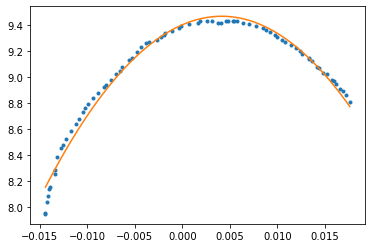

In [39]:
I_fit = np.linspace(min(I), max(I), 1001)
popt, pcov = opt.curve_fit(f_par, xdata=I, ydata=f, p0=(-0.1, 0, 10.42))
f_fit = f_par(I_fit, *popt)



plt.plot(I, f, '.')
plt.plot(I_fit, f_fit)

In [40]:
s.landscape.delete_landscape_function_xy()
s.landscape.delete_landscape_function_xz()
s.landscape.generate_fit_function_xy(curve_f='parab',
                                     curve_p=[I, f],
                                     p0=popt,
                                     y_span=750e6
                                    )

xz_landscape deleted


In [41]:
s.landscape.xylandscapes[0]['center_points'] *= 1e9
s.landscape.xylandscapes

[{'center_points': array([8.90363928e+09, 8.92666777e+09, 8.94921680e+09, 8.97128637e+09,
         8.99287647e+09, 9.01398711e+09, 9.03461829e+09, 9.05477001e+09,
         9.07444226e+09, 9.09363505e+09, 9.11234839e+09, 9.13058225e+09,
         9.14833666e+09, 9.16561160e+09, 9.18240709e+09, 9.19872311e+09,
         9.21455966e+09, 9.22991676e+09, 9.24479439e+09, 9.25919257e+09,
         9.27311128e+09, 9.28655052e+09, 9.29951031e+09, 9.31199063e+09,
         9.32399149e+09, 9.33551289e+09, 9.34655483e+09, 9.35711730e+09,
         9.36720032e+09, 9.37680387e+09, 9.38592795e+09, 9.39457258e+09,
         9.40273774e+09, 9.41042345e+09, 9.41762969e+09, 9.42435646e+09,
         9.43060378e+09, 9.43637163e+09, 9.44166003e+09, 9.44646896e+09,
         9.45079842e+09, 9.45464843e+09, 9.45801897e+09, 9.46091005e+09,
         9.46332167e+09, 9.46525383e+09, 9.46670652e+09, 9.46767975e+09,
         9.46817353e+09, 9.46818783e+09, 9.46772268e+09, 9.46677806e+09,
         9.46535399e+09, 9.4634504

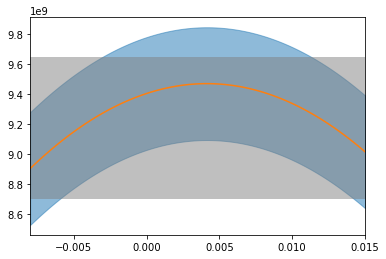

In [42]:
s.landscape.plot_xy_landscape()

In [43]:
IVD.ramp_current(dc_start, dc_step, dc_time)
IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)

In [44]:
#s.dirname = "GeQCoSv3_7_res_3_2tone_3D_landscape_current_" + str(round(dc_start/1e-3,1)) + "_to_"  + str(round(dc_stop/1e-3,1)) + "_mA"
s.dirname = exp_name + "_2tone_3D_landscape_current_" + str(round(dc_start/1e-3,1)) + "_to_"  + str(round(dc_stop/1e-3,1)) + "_mA"
IVD.set_status(True)
mw_src.set_status(True)
vna.get_all()
s.measure_3D()
mw_src.set_status(False)
IVD.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/12287) </td><td>&#9992; 2023-01-20 (Fri) 15:30:55    </td><t…

IntProgress(value=0, description='3D VNA sweep GeQCoS4Qv3_7C5_res1_2tone_3D_landscape_current_-8.0_to_15.0_mA'…

D:\data\EDEL_15\Alex\ROSEI0_3D_GeQCoS4Qv3_7C5_res1_2tone_3D_landscape_current_-8.0_to_15.0_mA\ROSEI0_3D_GeQCoS4Qv3_7C5_res1_2tone_3D_landscape_current_-8.0_to_15.0_mA.h5


In [45]:
IVD.set_status(False)
IVD.get_status()

False

Plots saved in D:\data\EDEL_15\Alex\ROSEI0_3D_GeQCoS4Qv3_7C5_res1_2tone_3D_landscape_current_-8.0_to_15.0_mA\images


In [ ]:
get_wiki_entry()